# Dispersive Readout for Transmon (1): Superconducting Qubits Dynamics under Readout Operation

In this Notebook, we aim to simulate the dynamics of qubit readout using quantum trajectory method, following 

In [10]:
!pip install qutip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import numpy as np
from numpy.matlib import repmat 
import scipy as sc
from scipy.special import erf
import scipy.constants as cn
import matplotlib.pyplot as plt

from qutip import *
from qutip.ipynbtools import parallel_map
%matplotlib inline

## Qubit System Setup

*此处的量均为除以 2$\pi$ 后的值，例如，求得的色散位移的值对应的是 $\chi/2\pi$* 

In [12]:
wr = 6.410 * 2*np.pi           # GHz
wq = 5.814 * 2*np.pi           # GHz
wd = (6.410+0.00) * 2*np.pi    # GHz

g = 95 * 1e-3 * 2*np.pi      # GHz
eta = -200 * 1e-3 * 2*np.pi    # GHz

kappa = 3 * 1e-3 * 2*np.pi     # 腔耗散率 GHz
T1 = 50 * 1e3                  # 比特相干时间 ns
Tphi = 20 * 1e3

Nr = 15; Nq = 3;               # Hilbert Space，Nr 取决于

a = tensor(destroy(Nr), qeye(Nq))
b = tensor(qeye(Nr), destroy(Nq))

x = a + a.dag()
y = -1.0j*(a - a.dag())

#### Characteristic Time for Measurement
This total measurement time should be realted to the cavity's dissipation rate: T~1/κ. In large and low injected $\bar{n}$, within and out of this timescale, the readout process shows different features. 

In [22]:
(1/kappa)

53.05164769729845

In [14]:
# critical photon numbers
n_crit = (wr-wq)**2/(4*g**2)
print('Critical photon number is :', n_crit)

chi01 = -(g/(2*np.pi))**2/((wq-wr)/(2*np.pi)) * 1e3  #换算成 MHz, 除以 2π 后的值
print('色散位移为   : ', chi01, ' MHz')
chi = -(g/(2*np.pi))**2/((wq-wr)/(2*np.pi)) * 1/(1+ (wq-wr)/eta) * 1e3  #换算成 MHz, 除以 2π 后的值
print(r'有效色散位移为: ', chi, ' MHz')
k = 2*chi*2*np.pi/(kappa*1e3)
print('比值 k= ', k)

Critical photon number is : 9.839778393351809
色散位移为   :  15.14261744966442  MHz
有效色散位移为:  3.804677751171964  MHz
比值 k=  2.5364518341146427


## Hamiltonian

Transmon系统中，比特与一个读取谐振腔(on-chip waveguid resonator)相连接，这样可以极大减小读取对于比特的 backaction，从而可以实现 QND。这时将整个系统分为三个子系统：系统，quantum pointer system, classical measurement apparatus. 

以下 $b,a,c$ 分别表示比特，腔，feedline 对应的湮灭算符。比特与腔可以用JC模型来描述:

$$
H/\hbar = -\frac{\omega_{q}}{2}\sigma_{z} + \omega_{r}a^{\dagger}a+g(a^{\dagger}\sigma_{-}+a\sigma_{+}) + H_{d}/\hbar
$$
考虑比特的高能级：
$$
H/\hbar = \omega_{q}b^{\dagger}b+\frac{\eta}{2}b^{\dagger}b^{\dagger}bb + \omega_{r}a^{\dagger}a+g(a^{\dagger}b+ab^{\dagger}) + H_{d}/\hbar
$$
三能级当然可以截断回二能级表示，但此时色散位移要改成 $\chi_{\mathrm{eff}}=-\frac{g^{2}}{\Delta}\frac{1}{1+Δ/η}$。


其中 $H_{d}$ 由读取腔的入射信号决定
$$
H_{d}/\hbar = \varepsilon(t)\left[a\exp(i \omega_{d}t)+a^{\dagger}\exp(-i \omega_{d}t)\right]
$$
其中 $\varepsilon(t)$ 为信号的包络。接下来 Under dispersive approximation, the $H_d$ keeps the original form but adds an additional coherent control term ~$g/Δ$ about the qubit. The total Hamiltonian becomes:


$$
H_{\mathrm{disp}}/ħ=\omega_{r}a^{\dagger}a-\frac{1}{2}(\tilde{\omega}_{q}+χ_{\mathrm{eff}})\sigma_{z}
+\varepsilon(t)\left[a\exp(-i \omega_{d}t)+a^{\dagger}\exp(i \omega_{d}t)\right]\\
+\frac{g\varepsilon(t)}{Δ}\left[σ_{-}\exp(i \omega_{d}t)+\sigma_{+}\exp(-i \omega_{d}t)\right]
$$

However, this straightforward expression of dispersive qubit readout belied the interesting dynamics hidden in this process. The standard Master equation cannot fully the dynamics and we have to unravel. We will discuss in when we come to the dynamics part.

In [15]:
b00 = tensor(basis(Nr, 0), basis(Nq, 0))
b01 = tensor(basis(Nr, 0), basis(Nq, 1))
#b02 = tensor(basis(Nr, 0), basis(Nq, 2))
b10 = tensor(basis(Nr, 1), basis(Nq, 0))
b11 = tensor(basis(Nr, 1), basis(Nq, 1))
#b12 = tensor(basis(Nr, 1), basis(Nq, 2))
b20 = tensor(basis(Nr, 2), basis(Nq, 0))
b21 = tensor(basis(Nr, 2), basis(Nq, 1))
#b22 = tensor(basis(Nr, 2), basis(Nq, 2))

H0 = wq * b.dag()*b + eta/2 * b.dag()*b.dag()*b*b + wr * a.dag()*a + g * ( a.dag() + a ) * ( b.dag() + b )
#H0 = wq * b.dag()*b + wr * a.dag()*a + g * (a.dag() * b + a * b.dag())


## Square Pulse
def H1_coeff(t, args):
    T = args['T']
    A = args['A']
    if t>=0 and t<T:
        pulse = A
    else:
        pulse = 0
    return pulse*np.exp(-1j*wd*t)

def H2_coeff(t, args):
    T = args['T']
    A = args['A']
    if t>=0 and t<T:
        pulse = A
    else:
        pulse = 0
    return pulse*np.exp(1j*wd*t)

# CLEAR
def H1_coeffc(t, args):
    T_steady = args['T_steady']
    T_kick = args['T_kick']
    A = args['A']
    V = args['V']
    
    if t >= 0 and t < T_steady:
        pulse = A
    elif t >= T_steady and t < T_steady+T_kick:
        pulse = -V
    elif t >= T_steady+T_kick and t < T_steady+2*T_kick:
        pulse = V
    else:
        pulse = 0
    return pulse*np.exp(-1j*wd*t)

def H2_coeffc(t, args):
    T_steady = args['T_steady']
    T_kick = args['T_kick']
    A = np.conjugate(args['A'])
    V = np.conjugate(args['V'])
    
    if t>=0 and t < T_steady:
        pulse = A
    elif t>= T_steady and t<T_steady+T_kick:
        pulse = -V
    elif t>=T_steady+T_kick and t < T_steady+2*T_kick:
        pulse = V
    else:
        pulse = 0
    return pulse*np.exp(1j*wd*t)

T = 400
tn = 0.625*5
t0 = 0
times = np.linspace(t0, T, int((T+t0)/tn)+1)

## Pulse parameters
args = {'A': 2, 'T':350}                                      # Square Pulse
argsc = {'A': 0.03, 'V': 0.01, 'T_kick':50, 'T_steady':200}      # Clear Pulse

## Pulse

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


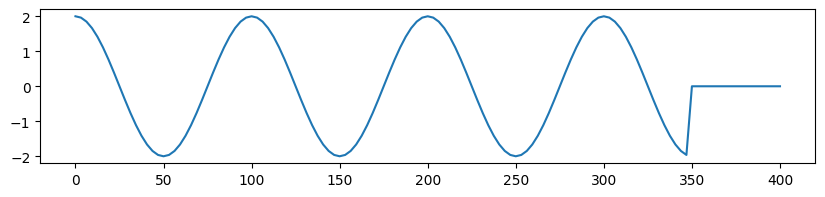

In [16]:
s1 = np.array([H1_coeff(t, args)  for t in times])
plt.figure(figsize=(10,2))
plt.plot(times, s1)

In [17]:
s2 = np.array([H2_coeff(t, args)  for t in times])

#### Hamiltonian, Collapse Operators, and Initial State

In [18]:
## Collapse Operators
nth = 0.063
c_ops = []
c_ops.append(np.sqrt(kappa * (1+nth)) * a)
c_ops.append(np.sqrt(kappa * nth) * a.dag())
c_ops.append(np.sqrt(1/T1)*b )
#c_ops.append( np.sqrt(1/2*Tphi)*b.dag()*b )

## Expectation
e_ops = [a.dag()*a, b.dag()*b, x, y, a]

## Hamiltonian
Hamiltonian = [ H0, [1j*np.sqrt(kappa)*a.dag(), H1_coeff], [-1j*np.sqrt(kappa)*a, H2_coeff] ]
#Hamiltonian = [ H0, [1j*np.sqrt(kappa)*a.dag(), H1_coeffc], [-1j*np.sqrt(kappa)*a, H2_coeffc] ]

psi0 = tensor(coherent(Nr, 0), basis(Nq, 0))
psi1 = tensor(coherent(Nr, 0), basis(Nq, 1))

#### The Dynamics of JC model
Condider the system Hamiltonian in interaction frame:
$$
H=ɛ(a^{†}+a)+χa^{†}aσ_{z}
$$
If the system undergoes weak coupling to a steady low-temperature bath, the Markovian evolution is governed by Lindblad form Master equation:
$$
\frac{dρ}{dt}=-i[ɛ(a^{†}+a), ρ]-i[χa^{†}aσ_{z}, ρ] + \mathcal{D}[a]ρ
$$

A steady state solution (long time limit) is: 

$$
ρ_{∞}=|c_{0}|^{2}|\alpha_{-}\rangle ⟨\alpha_{-}|⊗|0\rangle\langle 0|+|c_{1}|^{2}|\alpha_{+}\rangle ⟨\alpha_{+}|⊗|1\rangle\langle 1|
$$

This solution implies that the coherent states of resonator can be regarded as the **pointer states** to distinguish the qubits state. For the continuous measurement, the states $|α_{-}\rangle$, $|α_{+}\rangle$ are **conditioned states**, which would be explained in the SME part. 

Note that this solution assume that $T_{1}$ of qubits is reasonably large, otherwise we have to include the decay term of qubits $\sigma_{-}$, and then it is not possible to analytically solve this master equation. 

There are three common types of measurement in cQED system:
* Photon counting(direct measurement) 
* Homodyne measurement
* Heterodyne

The above results corresponds to photon counting. In Transmon readout, the heterodyne measurement is a common choice, so we have to consider the dynamics driven by output fields.

#### Readout Dynamics (Master Equation Approach)

Evolution of closed quantum system is Markovian. The [[Section 4.2.1, Wise & Melborn]](https://www.cambridge.org/ee/academic/subjects/physics/quantum-physics-quantum-information-and-quantum-computation/quantum-measurement-and-control?format=HB&isbn=9780521804424#contentsTabAnchor) showed us how to incorporate continuous measurement as **measurement operators** into the system evolution while preserving the Markovinality. The result reduces to the well-known Lindblad-form Master Equation. 

There are some requirements for measurement operators to preserve completeness of POVM.
* More than one measurement results
* At least one unitary, which correspond to no-measurement case

The measurement operator corrpesonding to a 'successful detection' (get result) is represented as: 
$$
\hat{M}_{1}(dt)=\sqrt{dt} \hat{c}
$$

For qubit-resonator composite system, the $c=\sqrt{γ}a$

In [19]:
meResult0 = mesolve(Hamiltonian, psi0, times, c_ops=c_ops, e_ops=e_ops, args=args, 
                    progress_bar=True,
                    options=Options(rhs_with_state=True, store_states=True, nsteps=20000))#, atol=10e-12, rtol=1e-8))
meResult1 = mesolve(Hamiltonian, psi1, times, c_ops=c_ops, e_ops=e_ops, args=args, 
                    progress_bar=True,
                    options=Options(rhs_with_state=True, store_states=True, nsteps=20000))#, atol=10e-12, rtol=1e-8))

10.1%. Run time:  45.33s. Est. time left: 00:00:06:44
20.2%. Run time:  77.67s. Est. time left: 00:00:05:07
30.2%. Run time: 108.13s. Est. time left: 00:00:04:09
40.3%. Run time: 138.30s. Est. time left: 00:00:03:24
50.4%. Run time: 166.90s. Est. time left: 00:00:02:44
60.5%. Run time: 196.28s. Est. time left: 00:00:02:08
70.5%. Run time: 225.14s. Est. time left: 00:00:01:34
80.6%. Run time: 253.58s. Est. time left: 00:00:01:00
90.7%. Run time: 283.76s. Est. time left: 00:00:00:29
Total run time: 307.90s
10.1%. Run time:  35.79s. Est. time left: 00:00:05:19
20.2%. Run time:  69.21s. Est. time left: 00:00:04:34
30.2%. Run time: 100.21s. Est. time left: 00:00:03:51
40.3%. Run time: 130.16s. Est. time left: 00:00:03:12
50.4%. Run time: 160.95s. Est. time left: 00:00:02:38
60.5%. Run time: 192.12s. Est. time left: 00:00:02:05
70.5%. Run time: 222.36s. Est. time left: 00:00:01:32
80.6%. Run time: 253.46s. Est. time left: 00:00:01:00
90.7%. Run time: 290.15s. Est. time left: 00:00:00:29
Tota

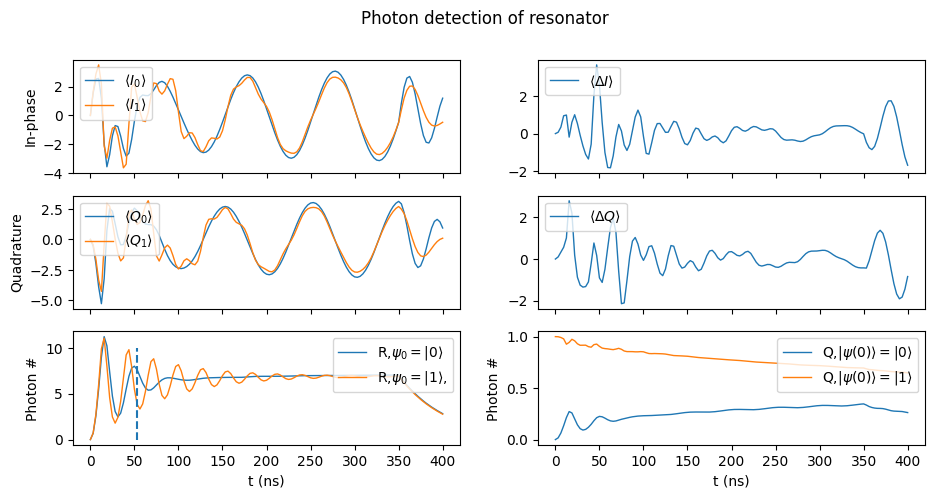

In [23]:
I0 = meResult0.expect[2]
Q0 = meResult0.expect[3]
I1 = meResult1.expect[2]
Q1 = meResult1.expect[3]
n_c0 = meResult0.expect[0]
n_q0 = meResult0.expect[1]
n_c1 = meResult1.expect[0]
n_q1 = meResult1.expect[1]

fig, axes = plt.subplots(3, 2, figsize=(11,5), sharex=True)
fig.suptitle('Photon detection of resonator')
axes[0,0].plot(times, I0, label=r'$\langle I_{0}\rangle$',lw=1)
axes[0,0].plot(times, I1, label=r'$\langle I_{1}\rangle$',lw=1)
axes[0,0].legend(loc='upper left')
axes[0,0].set_ylabel('In-phase')
axes[1,0].plot(times, Q0, label=r'$\langle Q_{0}\rangle$',lw=1)
axes[1,0].plot(times, Q1, label=r'$\langle Q_{1}\rangle$',lw=1)
axes[1,0].legend(loc='upper left')
axes[1,0].set_ylabel('Quadrature')

axes[0,1].plot(times, I1-I0, label=r'$\langle \Delta I\rangle$',lw=1)
axes[0,1].legend(loc='upper left')
axes[1,1].plot(times, Q1-Q0, label=r'$\langle \Delta Q\rangle$',lw=1)
axes[1,1].legend(loc='upper left')

axes[2,0].plot(times, n_c0, label = r'R,$\psi_{0}=|0\rangle$',lw=1)
axes[2,0].plot(times, n_c1, label = r'R,$\psi_{0}=|1\rangle$,',lw=1)
axes[2,0].vlines(times[int((1/kappa)/T*len(times))], 0, 10, linestyle='dashed')
axes[2,0].legend(loc='upper right')
axes[2,0].set_xlabel('t (ns)')
axes[2,0].set_ylabel('Photon #')

axes[2,1].plot(times, n_q0, label = r'Q,$|\psi(0)\rangle=|0\rangle$',lw=1)
axes[2,1].plot(times, n_q1, label = r'Q,$|\psi(0)\rangle=|1\rangle$',lw=1)
axes[2,1].legend(loc='upper right')
axes[2,1].set_xlabel('t (ns)')
axes[2,1].set_ylabel('Photon #')
fig.savefig('Readout dynamics')
plt.show()

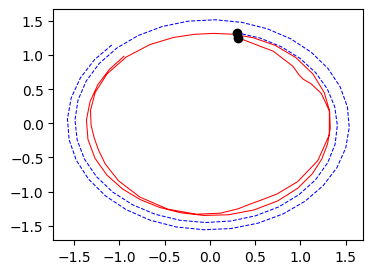

In [24]:
## Sampling dealy
n1 = 50
n2 = 110
Re_a0 = np.real(meResult0.expect[4][n1:n2])
Im_a0 = np.imag(meResult0.expect[4][n1:n2])
Re_a1 = np.real(meResult1.expect[4][n1:n2])
Im_a1 = np.imag(meResult1.expect[4][n1:n2])

ave_I0 = Re_a0.sum()/(n2-n1)
ave_Q0 = Im_a0.sum()/(n2-n1)
ave_I1 = Re_a1.sum()/(n2-n1)
ave_Q1 = Re_a1.sum()/(n2-n1)

fig = plt.figure(figsize=(4, 3))
plt.plot(Re_a0, Im_a0, '--', linewidth=0.75, color='blue')
plt.plot(Re_a1, Im_a1, linewidth=0.75, color='red')
plt.plot(Re_a0[0], Im_a0[0], marker='o', color='black')
plt.plot(Re_a1[0], Im_a1[0], marker='o', color='black')

### Output Field Signal
The input-outout relationship gives rise to the boundary condition for the EM fields between readout resonator and the feedline:
$$
c_{in}(t)-c_{out}(t)= \sqrt{κ}a(t)
$$
Further we combine this condition to the Quantum Langevin euqaiton of optical cavity, we can derive the relationship between $c_{out}$ and $a$: 
$$
c_{out}(t)=\frac{\frac{\kappa}{2}-i(Δ-χ_{\mathrm{eff}} σ_{z})}{\frac{\kappa}{2}+i(Δ-χ_{\mathrm{eff}} σ_{z})}c_{in}(t)=\frac{\frac{\kappa}{2}-i(Δ-χ_{\mathrm{eff}} σ_{z})}{\sqrt{\kappa}}a(t)
$$
For the classical part of the field:
$$
\langle c_{out}(t)\rangle=\frac{\frac{\kappa}{2}-i(Δ-χ_{\mathrm{eff}} σ_{z})}{\sqrt{\kappa}}\langle a(t)⟩
$$
The quantum noise of output field are governed by:
$$
\langle c_{out}(t^{\prime}), c_{out}(t)\rangle = \kappa\langle a(t^{\prime}), a(t)\rangle,
$$
where the $\langle U, V\rangle=\langle UV\rangle -\langle U\rangle\langle V\rangle$. 


/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


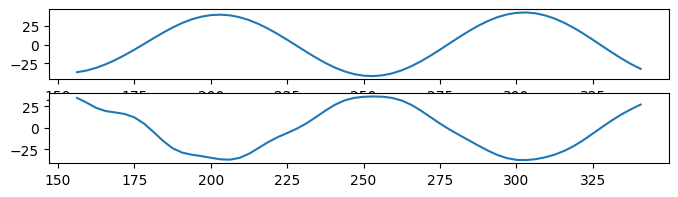

In [33]:
RF_out_0 = (kappa/(2)-1j*((wd-wr)-chi))/np.sqrt(kappa) * (Re_a0+1j*Im_a0)
RF_out_1 = (kappa/(2)-1j*((wd-wr)+chi))/np.sqrt(kappa) * (Re_a1+1j*Im_a1)

t_samples = times[n1:n2]

fig, axes = plt.subplots(2, 1, figsize=(8, 2))
axes[0].plot(t_samples, RF_out_0)
axes[1].plot(t_samples, RF_out_1)

Text(0.5, 0, 't (ns)')

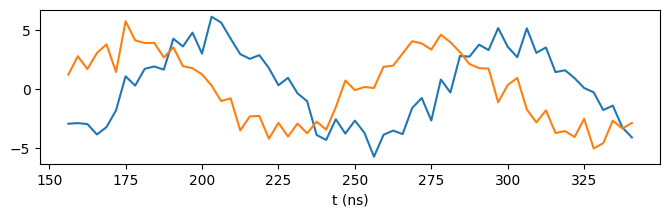

In [45]:
## Repeat the measurement
repeat = 1000
RF_I0_mat = repmat(np.real(RF_out_0), 1000, 1)
RF_Q0_mat = repmat(np.imag(RF_out_0), 1000, 1)
RF_I1_mat = repmat(np.real(RF_out_1), 1000, 1)
RF_Q1_mat = repmat(np.imag(RF_out_1), 1000, 1)

## Add Gaussian noise
noisy_RF_I0 = RF_I0_mat/10 + np.random.randn(repeat, len(t_samples))
noisy_RF_Q0 = RF_Q0_mat/10 + np.random.randn(repeat, len(t_samples))
noisy_RF_I1 = RF_I1_mat/10 + np.random.randn(repeat, len(t_samples))
noisy_RF_Q1 = RF_Q1_mat/10 + np.random.randn(repeat, len(t_samples))

plt.figure(figsize=(8,2))
plt.plot(t_samples, noisy_RF_I0[3,:])
plt.plot(t_samples, noisy_RF_Q0[3,:])
plt.xlabel('t (ns)')

(-40.940185200956115,
 44.19422211616288,
 -30.975068973636496,
 25.425589887343477)

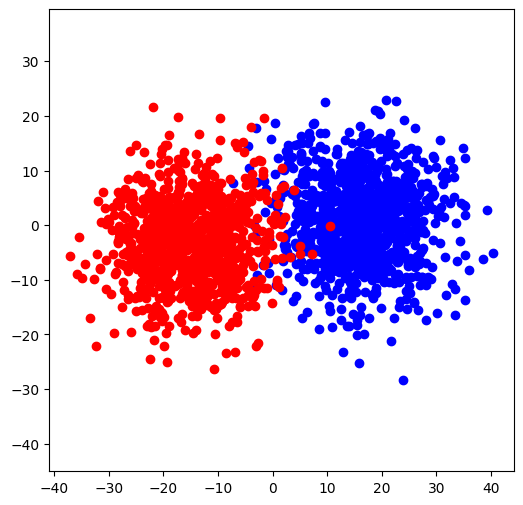

In [49]:
Av_IF_I0 = noisy_RF_I0.sum(axis=1)
Av_IF_Q0 = noisy_RF_Q0.sum(axis=1)
Av_IF_I1 = noisy_RF_I1.sum(axis=1)
Av_IF_Q1 = noisy_RF_Q1.sum(axis=1)

plt.figure(figsize=(6,6))
plt.scatter(Av_IF_I0, Av_IF_Q0, marker='o', color='blue')
plt.scatter(Av_IF_I1, Av_IF_Q1, marker='o', color='red')
plt.axis('equal')

Text(0.5, 0, 't (ns)')

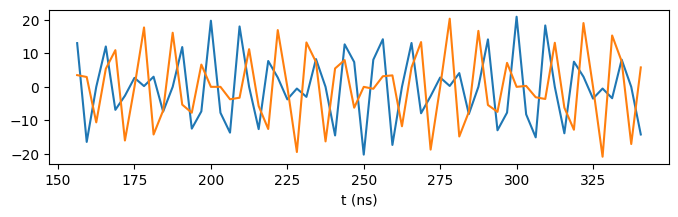

In [37]:
fs_ADC = 1.6    # GHz, ADC sampling frequency
fs = 40         # GHz, Filter sampling frequency

def down_convert(y, t, w_LO, phi0=0):
    '''Down-convert the RF signal'''
    LO = np.cos(2*np.pi * w_LO*t + phi0)
    return LO*y

w_LO = 6.5         # GHz

IF_I0 = 1/2*down_convert(noisy_RF_I0, times[n1:n2], w_LO)
IF_Q0 = 1/2*down_convert(noisy_RF_Q0, times[n1:n2], w_LO, phi0=np.pi/2)

plt.figure(figsize=(8,2))
plt.plot(t_samples, IF_I0[3,:])
plt.plot(t_samples, IF_Q0[3,:])
plt.xlabel('t (ns)')

### Important quantities

* Measurement time : It is artificial in experiments. [Gambetta, J., 2006.](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.74.042318) It is related to the quantum efficiency of measurement by: $t_{mea}Γ_{m}=\frac{1}{η}$ 
* Measurement-induced decoherence
* 

### Two Ways of Quantum Unravelling
* Jump-like
* Difussion-like


#### Dynamics (Quantum Jump Approach - 1)

In [ ]:
mcResult0 = mcsolve(Hamiltonian, psi0, times, 
                    c_ops=c_ops, 
                    e_ops=e_ops, 
                    ntraj=150, 
                    args=args, 
                    progress_bar=True, 
                    options=Options(rhs_with_state=True, store_states=True))#, atol=10e-12, rtol=1e-8))
mcResult1 = mcsolve(Hamiltonian, psi1, times, 
                    c_ops=c_ops, 
                    e_ops=e_ops, 
                    ntraj=150, 
                    args=args, 
                    progress_bar=True,
                    options=Options(rhs_with_state=True, store_states=True))#, atol=10e-12, rtol=1e-8))

10.0%. Run time: 786.78s. Est. time left: 00:01:58:01
20.0%. Run time: 1509.21s. Est. time left: 00:01:40:36
30.0%. Run time: 2280.57s. Est. time left: 00:01:28:41
40.0%. Run time: 2992.04s. Est. time left: 00:01:14:48
50.0%. Run time: 3791.53s. Est. time left: 00:01:03:11
60.0%. Run time: 4507.82s. Est. time left: 00:00:50:05
70.0%. Run time: 5291.28s. Est. time left: 00:00:37:47
80.0%. Run time: 6010.55s. Est. time left: 00:00:25:02
90.0%. Run time: 6778.56s. Est. time left: 00:00:12:33
100.0%. Run time: 7500.27s. Est. time left: 00:00:00:00
Total run time: 7500.28s
10.0%. Run time: 820.60s. Est. time left: 00:02:03:05
20.0%. Run time: 1544.07s. Est. time left: 00:01:42:56
30.0%. Run time: 2342.39s. Est. time left: 00:01:31:05
40.0%. Run time: 3054.71s. Est. time left: 00:01:16:22
50.0%. Run time: 3836.34s. Est. time left: 00:01:03:56
60.0%. Run time: 4570.15s. Est. time left: 00:00:50:46
70.0%. Run time: 5340.53s. Est. time left: 00:00:38:08
80.0%. Run time: 6058.57s. Est. time left

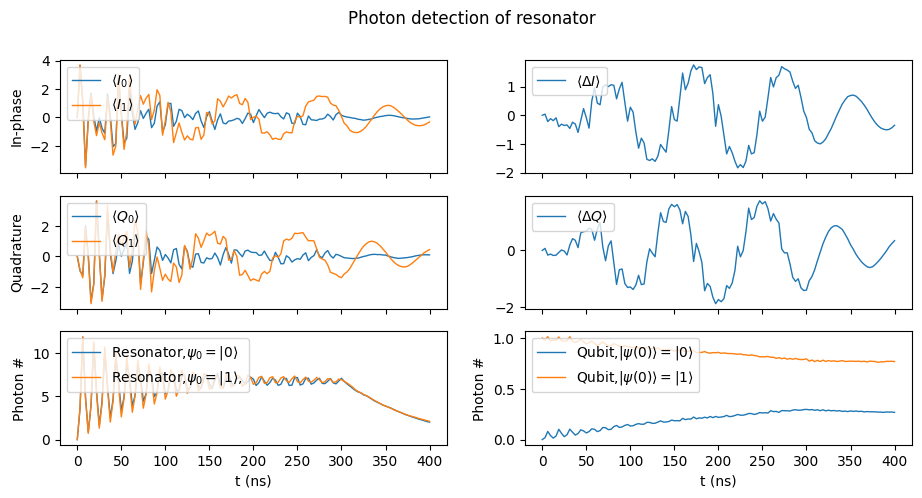

In [ ]:
I0 = mcResult0.expect[2]
Q0 = mcResult0.expect[3]
I1 = mcResult1.expect[2]
Q1 = mcResult1.expect[3]
n_c0 = mcResult0.expect[0]
n_q0 = mcResult0.expect[1]
n_c1 = mcResult1.expect[0]
n_q1 = mcResult1.expect[1]

fig, axes = plt.subplots(3, 2, figsize=(11,5), sharex=True)
fig.suptitle('Photon detection of resonator')
axes[0,0].plot(times, I0, label=r'$\langle I_{0}\rangle$',lw=1)
axes[0,0].plot(times, I1, label=r'$\langle I_{1}\rangle$',lw=1)
axes[0,0].legend(loc='upper left')
axes[0,0].set_ylabel('In-phase')
axes[1,0].plot(times, Q0, label=r'$\langle Q_{0}\rangle$',lw=1)
axes[1,0].plot(times, Q1, label=r'$\langle Q_{1}\rangle$',lw=1)
axes[1,0].legend(loc='upper left')
axes[1,0].set_ylabel('Quadrature')

axes[0,1].plot(times, I1-I0, label=r'$\langle \Delta I\rangle$',lw=1)
axes[0,1].legend(loc='upper left')
axes[1,1].plot(times, Q1-Q0, label=r'$\langle \Delta Q\rangle$',lw=1)
axes[1,1].legend(loc='upper left')

axes[2,0].plot(times, n_c0, label = r'Resonator,$\psi_{0}=|0\rangle$',lw=1)
axes[2,0].plot(times, n_c1, label = r'Resonator,$\psi_{0}=|1\rangle$,',lw=1)
axes[2,0].legend(loc='upper left')
axes[2,0].set_xlabel('t (ns)')
axes[2,0].set_ylabel('Photon #')

axes[2,1].plot(times, n_q0, label = r'Qubit,$|\psi(0)\rangle=|0\rangle$',lw=1)
axes[2,1].plot(times, n_q1, label = r'Qubit,$|\psi(0)\rangle=|1\rangle$',lw=1)
axes[2,1].legend(loc='upper left')
axes[2,1].set_xlabel('t (ns)')
axes[2,1].set_ylabel('Photon #')
fig.savefig('Readout dynamics')
plt.show()



#### Dynamics (Quantum Jump Approach - 1 - less trajectories)

In [ ]:
mcResult0 = mcsolve(Hamiltonian, psi0, times, 
                    c_ops=c_ops, 
                    e_ops=e_ops, 
                    ntraj=100, 
                    args=args, 
                    progress_bar=True, 
                    options=Options(rhs_with_state=True, store_states=True))#, atol=10e-12, rtol=1e-8))
mcResult1 = mcsolve(Hamiltonian, psi1, times, 
                    c_ops=c_ops, 
                    e_ops=e_ops, 
                    ntraj=100, 
                    args=args, 
                    progress_bar=True,
                    options=Options(rhs_with_state=True, store_states=True))#, atol=10e-12, rtol=1e-8))

10.0%. Run time: 545.32s. Est. time left: 00:01:21:47
20.0%. Run time: 1069.71s. Est. time left: 00:01:11:18
30.0%. Run time: 1601.88s. Est. time left: 00:01:02:17
40.0%. Run time: 2122.29s. Est. time left: 00:00:53:03
50.0%. Run time: 2633.09s. Est. time left: 00:00:43:53
60.0%. Run time: 3159.76s. Est. time left: 00:00:35:06
70.0%. Run time: 3676.72s. Est. time left: 00:00:26:15
80.0%. Run time: 4201.72s. Est. time left: 00:00:17:30
90.0%. Run time: 4711.50s. Est. time left: 00:00:08:43
100.0%. Run time: 5199.90s. Est. time left: 00:00:00:00
Total run time: 5199.91s
10.0%. Run time: 522.90s. Est. time left: 00:01:18:26
20.0%. Run time: 1044.45s. Est. time left: 00:01:09:37
30.0%. Run time: 1557.69s. Est. time left: 00:01:00:34
40.0%. Run time: 2085.27s. Est. time left: 00:00:52:07
50.0%. Run time: 2606.50s. Est. time left: 00:00:43:26
60.0%. Run time: 3132.62s. Est. time left: 00:00:34:48
70.0%. Run time: 3660.48s. Est. time left: 00:00:26:08
80.0%. Run time: 4186.62s. Est. time left

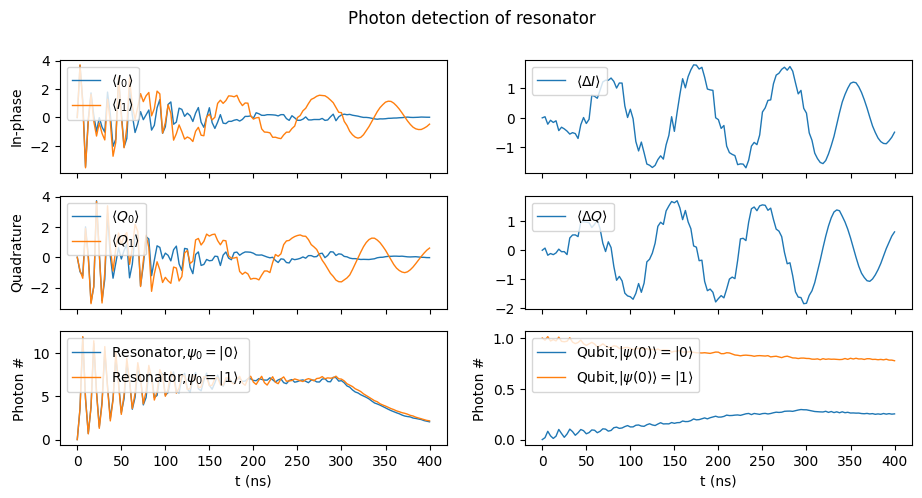

In [ ]:
I0 = mcResult0.expect[2]
Q0 = mcResult0.expect[3]
I1 = mcResult1.expect[2]
Q1 = mcResult1.expect[3]
n_c0 = mcResult0.expect[0]
n_q0 = mcResult0.expect[1]
n_c1 = mcResult1.expect[0]
n_q1 = mcResult1.expect[1]

fig, axes = plt.subplots(3, 2, figsize=(11,5), sharex=True)
fig.suptitle('Photon detection of resonator')
axes[0,0].plot(times, I0, label=r'$\langle I_{0}\rangle$',lw=1)
axes[0,0].plot(times, I1, label=r'$\langle I_{1}\rangle$',lw=1)
axes[0,0].legend(loc='upper left')
axes[0,0].set_ylabel('In-phase')
axes[1,0].plot(times, Q0, label=r'$\langle Q_{0}\rangle$',lw=1)
axes[1,0].plot(times, Q1, label=r'$\langle Q_{1}\rangle$',lw=1)
axes[1,0].legend(loc='upper left')
axes[1,0].set_ylabel('Quadrature')

axes[0,1].plot(times, I1-I0, label=r'$\langle \Delta I\rangle$',lw=1)
axes[0,1].legend(loc='upper left')
axes[1,1].plot(times, Q1-Q0, label=r'$\langle \Delta Q\rangle$',lw=1)
axes[1,1].legend(loc='upper left')

axes[2,0].plot(times, n_c0, label = r'Resonator,$\psi_{0}=|0\rangle$',lw=1)
axes[2,0].plot(times, n_c1, label = r'Resonator,$\psi_{0}=|1\rangle$,',lw=1)
axes[2,0].legend(loc='upper left')
axes[2,0].set_xlabel('t (ns)')
axes[2,0].set_ylabel('Photon #')

axes[2,1].plot(times, n_q0, label = r'Qubit,$|\psi(0)\rangle=|0\rangle$',lw=1)
axes[2,1].plot(times, n_q1, label = r'Qubit,$|\psi(0)\rangle=|1\rangle$',lw=1)
axes[2,1].legend(loc='upper left')
axes[2,1].set_xlabel('t (ns)')
axes[2,1].set_ylabel('Photon #')
fig.savefig('Readout dynamics')
plt.show()

#### Dynamics (Quantum Jump Approach - 1 - xxx)

In [ ]:
mcResult0 = mcsolve(Hamiltonian, psi0, times, 
                    c_ops=c_ops, 
                    e_ops=e_ops, 
                    ntraj=150, 
                    args=args, 
                    progress_bar=True, 
                    options=Options(rhs_with_state=True, store_states=True, rhs_reuse=True))#, atol=10e-12, rtol=1e-8))
mcResult1 = mcsolve(Hamiltonian, psi1, times, 
                    c_ops=c_ops, 
                    e_ops=e_ops, 
                    ntraj=150, 
                    args=args, 
                    progress_bar=True,
                    options=Options(rhs_with_state=True, store_states=True, rhs_reuse=True))#, atol=10e-12, rtol=1e-8))

10.0%. Run time: 852.06s. Est. time left: 00:02:07:48
20.0%. Run time: 1580.12s. Est. time left: 00:01:45:20
30.0%. Run time: 2377.52s. Est. time left: 00:01:32:27
40.0%. Run time: 3083.91s. Est. time left: 00:01:17:05
50.0%. Run time: 3875.34s. Est. time left: 00:01:04:35
60.0%. Run time: 4583.58s. Est. time left: 00:00:50:55
70.0%. Run time: 5394.26s. Est. time left: 00:00:38:31
80.0%. Run time: 6114.63s. Est. time left: 00:00:25:28
90.0%. Run time: 6916.91s. Est. time left: 00:00:12:48
100.0%. Run time: 7619.26s. Est. time left: 00:00:00:00
Total run time: 7619.29s
10.0%. Run time: 815.05s. Est. time left: 00:02:02:15
20.0%. Run time: 1542.40s. Est. time left: 00:01:42:49
30.0%. Run time: 2347.27s. Est. time left: 00:01:31:16
40.0%. Run time: 3107.78s. Est. time left: 00:01:17:41
50.0%. Run time: 3914.76s. Est. time left: 00:01:05:14
60.0%. Run time: 4666.41s. Est. time left: 00:00:51:50
70.0%. Run time: 5467.53s. Est. time left: 00:00:39:03
80.0%. Run time: 6232.56s. Est. time left

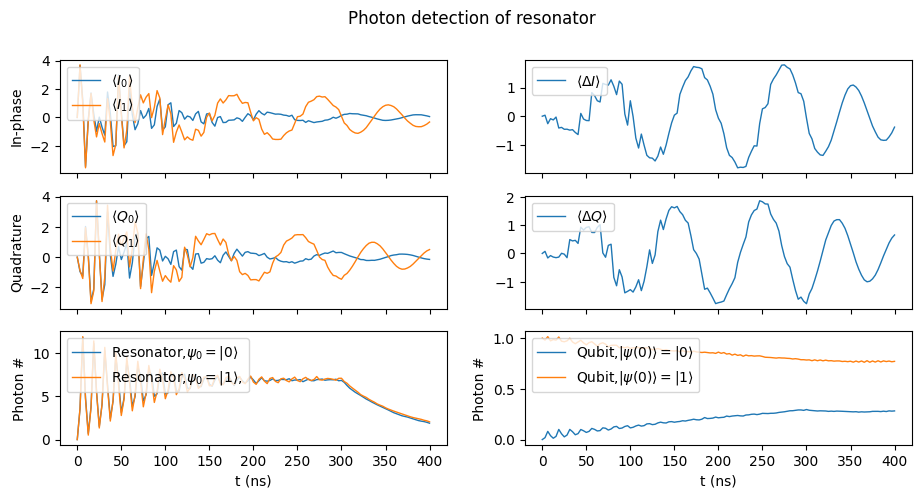

In [ ]:
I0 = mcResult0.expect[2]
Q0 = mcResult0.expect[3]
I1 = mcResult1.expect[2]
Q1 = mcResult1.expect[3]
n_c0 = mcResult0.expect[0]
n_q0 = mcResult0.expect[1]
n_c1 = mcResult1.expect[0]
n_q1 = mcResult1.expect[1]

fig, axes = plt.subplots(3, 2, figsize=(11,5), sharex=True)
fig.suptitle('Photon detection of resonator')
axes[0,0].plot(times, I0, label=r'$\langle I_{0}\rangle$',lw=1)
axes[0,0].plot(times, I1, label=r'$\langle I_{1}\rangle$',lw=1)
axes[0,0].legend(loc='upper left')
axes[0,0].set_ylabel('In-phase')
axes[1,0].plot(times, Q0, label=r'$\langle Q_{0}\rangle$',lw=1)
axes[1,0].plot(times, Q1, label=r'$\langle Q_{1}\rangle$',lw=1)
axes[1,0].legend(loc='upper left')
axes[1,0].set_ylabel('Quadrature')

axes[0,1].plot(times, I1-I0, label=r'$\langle \Delta I\rangle$',lw=1)
axes[0,1].legend(loc='upper left')
axes[1,1].plot(times, Q1-Q0, label=r'$\langle \Delta Q\rangle$',lw=1)
axes[1,1].legend(loc='upper left')

axes[2,0].plot(times, n_c0, label = r'Resonator,$\psi_{0}=|0\rangle$',lw=1)
axes[2,0].plot(times, n_c1, label = r'Resonator,$\psi_{0}=|1\rangle$,',lw=1)
axes[2,0].legend(loc='upper left')
axes[2,0].set_xlabel('t (ns)')
axes[2,0].set_ylabel('Photon #')

axes[2,1].plot(times, n_q0, label = r'Qubit,$|\psi(0)\rangle=|0\rangle$',lw=1)
axes[2,1].plot(times, n_q1, label = r'Qubit,$|\psi(0)\rangle=|1\rangle$',lw=1)
axes[2,1].legend(loc='upper left')
axes[2,1].set_xlabel('t (ns)')
axes[2,1].set_ylabel('Photon #')
fig.savefig('Readout dynamics')
plt.show()

In [ ]:
ntraj_list = [2]*50

mcResult1 = mcsolve(Hamiltonian, psi1, times, 
                    c_ops=c_ops, 
                    e_ops=e_ops, 
                    ntraj=ntraj_list, 
                    args=args, 
                    progress_bar=True,
                    options=Options(rhs_with_state=True, store_states=True))#, atol=10e-12, rtol=1e-8))

50.0%. Run time: 110.31s. Est. time left: 00:00:01:50
100.0%. Run time: 110.95s. Est. time left: 00:00:00:00
Total run time: 110.99s


In [ ]:
len(mcResult1.expect)

50

#### Dynamics (Quantum Jump Approach 2)
When a quantum system is subjected to continuous measurement, 

Refer to [qutip]() implementation of stochastic solver. 

To simulate readout dynamics of Transmon, let us fork [QuTip-tutorial - Stochastic Solver: Heterodyne Detection](https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v4/time-evolution/015_smesolve-heterodyne.ipynb). Homodyne and hetrodyne detection are techniques for measuring the quadratures of a field using photocounters. However, for measurement of superconducting qubits states, the information is extracted via the demodulation of microwave field but not well- 'photocounters'.


Conditioned state: $|0,g\rangle$ or $| 0,e\rangle$

The SSE and SME are explained in both Melborn and QuTip. SSE or SME help us to unravel the deterministic Markovian dynamics (governed by Lindblad Master Equation) into a set of **trajectories**. 

**Note**: The stochastic solver may give rise to unphysical results (see [QuTip-TUT](https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v4/time-evolution/015_smesolve-heterodyne.ipynb)). For this circuitQED system, an appropriate option is 



#### Homodyne and Heterodyne Detection

In [ ]:
sc_ops = [np.sqrt(kappa)*a]
ntraj = 100
nsubsteps = 100
options=Options(rhs_with_state=True, store_states=True)

stocResult0 = smesolve(Hamiltonian, psi0, times,
                            c_ops=[],
                            sc_ops=sc_ops,
                            e_ops=e_ops,
                            ntraj=ntraj,
                            nsubsteps=nsubsteps,
                            args=args,
                            solver="taylor15",
                            method="homodyne",
                            store_measurement=True,
                            map_func=parallel_map,
                            progress_bar=True,
                            options=options)
stocResult1 = smesolve(Hamiltonian, psi1, times,
                            c_ops=[],
                            sc_ops=sc_ops,
                            e_ops=e_ops,
                            ntraj=ntraj,
                            nsubsteps=nsubsteps,
                            args=args,
                            solver="taylor15",
                            method="homodyne",
                            store_measurement=True,
                            map_func=parallel_map,
                            progress_bar=True,
                            options=options)

10.0%. Run time: 297.18s. Est. time left: 00:00:44:34
20.0%. Run time: 590.99s. Est. time left: 00:00:39:23
30.0%. Run time: 883.09s. Est. time left: 00:00:34:20
40.0%. Run time: 1175.09s. Est. time left: 00:00:29:22
50.0%. Run time: 1467.36s. Est. time left: 00:00:24:27
60.0%. Run time: 1760.71s. Est. time left: 00:00:19:33
70.0%. Run time: 2053.88s. Est. time left: 00:00:14:40
80.0%. Run time: 2346.57s. Est. time left: 00:00:09:46
90.0%. Run time: 2638.26s. Est. time left: 00:00:04:53
100.0%. Run time: 2930.75s. Est. time left: 00:00:00:00
Total run time: 2930.77s
10.0%. Run time: 293.34s. Est. time left: 00:00:44:00
20.0%. Run time: 588.56s. Est. time left: 00:00:39:14
30.0%. Run time: 880.44s. Est. time left: 00:00:34:14
40.0%. Run time: 1172.96s. Est. time left: 00:00:29:19
50.0%. Run time: 1465.12s. Est. time left: 00:00:24:25
60.0%. Run time: 1758.47s. Est. time left: 00:00:19:32
70.0%. Run time: 2051.42s. Est. time left: 00:00:14:39
80.0%. Run time: 2343.80s. Est. time left: 00

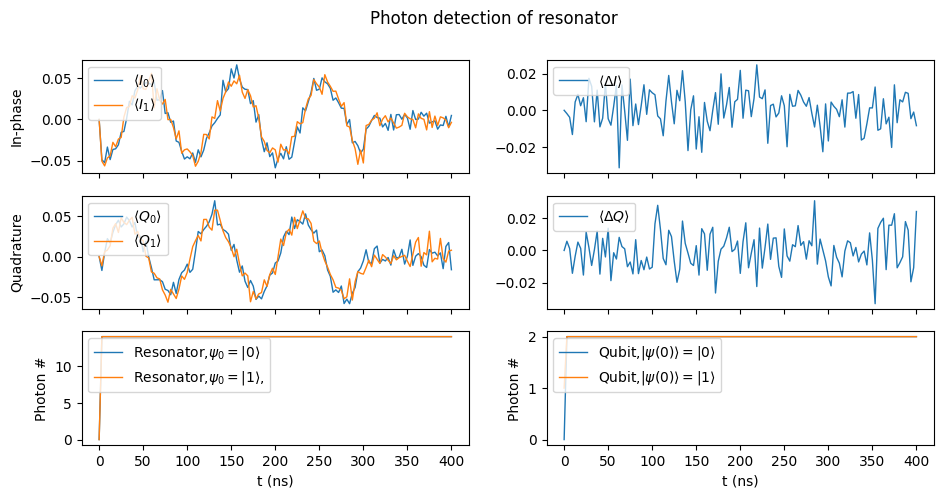

In [ ]:
I0 = stocResult0.expect[2]
Q0 = stocResult0.expect[3]
I1 = stocResult1.expect[2]
Q1 = stocResult1.expect[3]
n_c0 = stocResult0.expect[0]
n_q0 = stocResult0.expect[1]
n_c1 = stocResult1.expect[0]
n_q1 = stocResult1.expect[1]

fig, axes = plt.subplots(3, 2, figsize=(11,5), sharex=True)
fig.suptitle('Photon detection of resonator')
axes[0,0].plot(times, I0, label=r'$\langle I_{0}\rangle$',lw=1)
axes[0,0].plot(times, I1, label=r'$\langle I_{1}\rangle$',lw=1)
axes[0,0].legend(loc='upper left')
axes[0,0].set_ylabel('In-phase')
axes[1,0].plot(times, Q0, label=r'$\langle Q_{0}\rangle$',lw=1)
axes[1,0].plot(times, Q1, label=r'$\langle Q_{1}\rangle$',lw=1)
axes[1,0].legend(loc='upper left')
axes[1,0].set_ylabel('Quadrature')

axes[0,1].plot(times, I1-I0, label=r'$\langle \Delta I\rangle$',lw=1)
axes[0,1].legend(loc='upper left')
axes[1,1].plot(times, Q1-Q0, label=r'$\langle \Delta Q\rangle$',lw=1)
axes[1,1].legend(loc='upper left')

axes[2,0].plot(times, n_c0, label = r'Resonator,$\psi_{0}=|0\rangle$',lw=1)
axes[2,0].plot(times, n_c1, label = r'Resonator,$\psi_{0}=|1\rangle$,',lw=1)
axes[2,0].legend(loc='upper left')
axes[2,0].set_xlabel('t (ns)')
axes[2,0].set_ylabel('Photon #')

axes[2,1].plot(times, n_q0, label = r'Qubit,$|\psi(0)\rangle=|0\rangle$',lw=1)
axes[2,1].plot(times, n_q1, label = r'Qubit,$|\psi(0)\rangle=|1\rangle$',lw=1)
axes[2,1].legend(loc='upper left')
axes[2,1].set_xlabel('t (ns)')
axes[2,1].set_ylabel('Photon #')
fig.savefig('Readout dynamics')
plt.show()

#### Output field: Input-output relation

$$
c_{in}(t)-c_{out}(t)= \sqrt{κ}a(t)
$$

### Example: Feedback Control: Feedback stabilized Rabi oscillations


See [(7.5, Hadfield, Johansson et al., Superconducting Devices in Quantum Optics)](https://eprints.gla.ac.uk/117538/).

## Effective Hamiltonian

比特与腔可以用JC模型来描述:

$$
H/\hbar = -\frac{\tilde{\omega}_{q}}{2}\sigma_{z} + \Delta_{r}a^{\dagger}a+ \chi a^{\dagger}a \space\sigma_{z}+ H_{d}/\hbar
$$
其中 $\tilde{\omega}_{q}=\omega_{q}+\chi$。考虑比特的高能级：
$$
H/\hbar = -\frac{\tilde{\omega}_{q}}{2}\sigma_{z} + \Delta_{r}a^{\dagger}a+ \chi_{\mathrm{eff}}\space a^{\dagger}a \space\sigma_{z}+ H_{d}/\hbar
$$

其中 $H_{d}$ 由读取腔的入射信号决定
$$
H_{d}/\hbar = \varepsilon(t)a^{\dagger} + \varepsilon^{*}(t) a
$$
其中 $\varepsilon(t)$ 为信号的包络

根据输入输出关系，腔外场为读取信号与出射信号的和，输入腔内的控制信号为腔的散射系数与读取信号的某种乘积。

In [ ]:
# 二能级
Nr = 20; Nq = 2; 
a = tensor(destroy(Nr), qeye(Nq))
sz = tensor(qeye(Nr), sigmaz())
sm = tensor(qeye(Nr), destroy(Nq))

b00 = tensor(basis(Nr, 0), basis(Nq, 0))
b01 = tensor(basis(Nr, 0), basis(Nq, 1))
#b02 = tensor(basis(Nr, 0), basis(Nq, 2))
b10 = tensor(basis(Nr, 1), basis(Nq, 0))
b11 = tensor(basis(Nr, 1), basis(Nq, 1))
#b12 = tensor(basis(Nr, 1), basis(Nq, 2))
b20 = tensor(basis(Nr, 2), basis(Nq, 0))
b21 = tensor(basis(Nr, 2), basis(Nq, 1))
#b22 = tensor(basis(Nr, 2), basis(Nq, 2))

psi0 = b01

H0_eff = (wq-chi) * sz + (wr-wd) * a.dag()*a + chi* a.dag()*a*sz

## Dynamics(Effective)

In [ ]:
c_ops = [np.sqrt(kappa)*a, np.sqrt(1/T1)*sm]#, np.sqrt(1/Tphi)*(b00*b00.dag()-b01*b01.dag())]
e_ops = [a.dag()*a, sm.dag()*sm]

def H_eff_clear(t, args):
    T_steady = args['T_steady']
    T_kick = args['T_kick']
    A = args['A']
    V = args['V']
    
    if t<0:
        pulse = 0
    elif t >= 0 and t < T_steady:
        pulse = A
    elif t >= T_steady and t < T_steady+T_kick:
        pulse = -V
    elif t >= T_steady+T_kick and t < T_steady+ 2*T_kick:
        pulse = V/2
    else:
        pulse = 0
    return pulse

Hamiltonian_eff = [H0_eff, [a.dag()+a, H_eff_clear]]

result = mesolve(Hamiltonian_eff, psi0, times, c_ops, e_ops, args=argsc, progress_bar=True,\
                 options=Options(rhs_with_state=True, store_states=True, nsteps=8000, atol=10e-12, rtol=1e-8))


n_c = result.expect[0]
n_q = result.expect[1]

states = result.states

10.1%. Run time:   2.03s. Est. time left: 00:00:00:18
20.1%. Run time:   4.54s. Est. time left: 00:00:00:18
30.1%. Run time:   7.16s. Est. time left: 00:00:00:16
40.1%. Run time:   9.67s. Est. time left: 00:00:00:14
50.1%. Run time:  12.64s. Est. time left: 00:00:00:12
60.0%. Run time:  13.97s. Est. time left: 00:00:00:09
70.0%. Run time:  14.12s. Est. time left: 00:00:00:06
80.0%. Run time:  14.19s. Est. time left: 00:00:00:03
90.0%. Run time:  14.27s. Est. time left: 00:00:00:01
Total run time:  14.35s


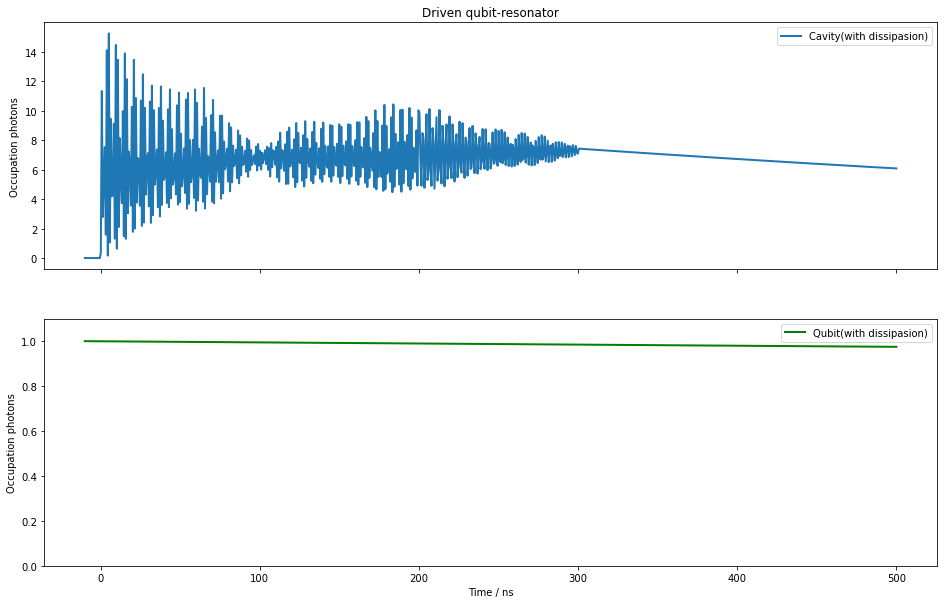

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (16, 10), sharex=True)

axes[0].set_title('Driven qubit-resonator')
axes[0].plot(times, n_c, label = 'Cavity(with dissipasion)', lw=2)
axes[0].legend(loc = 'best')
axes[0].set_ylabel('Occupation photons')
#axes[0].set_ylim(0.06, 0.07)
axes[1].plot(times, n_q, label = 'Qubit(with dissipasion)', color='green', lw=2)
axes[1].legend(loc = 'best')
axes[1].set_ylabel('Occupation photons')
axes[1].set_ylim(0.0, 1.1)
axes[1].set_xlabel('Time / ns')

plt.show()